In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))

%matplotlib inline
import matplotlib.pyplot as plt
import my_utils as utils
import numpy as np
import pandas as pd

BASE_PATH_CONCAT = os.path.join("results", "early_concat")
BASE_PATH_FUSION = os.path.join("results", "late_fusion")

## IEMOCAP



In [2]:
DATASET = "IEMOCAP"


def get_result_dataframe(dataset: str) -> pd.DataFrame:
    fusion_path = os.path.join(BASE_PATH_FUSION, dataset, "preds_test.json")
    concat_path = os.path.join(BASE_PATH_CONCAT, dataset, "preds_test_normal.json")

    fusion_df = utils.build_result_dataframe(fusion_path)
    concat_df = utils.build_result_dataframe(concat_path)

    assert len(fusion_df) == len(concat_df)

    results = utils.merge_result_dataframes([fusion_df, concat_df], ["fusion", "concat"])

    return results


df = get_result_dataframe(DATASET)
df.head(3)

,input,output,target,certainty,gate,input_concat,output_concat
index,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,neutral,0.532227,"[0.389404296875, 0.0396728515625]",Now you are expert of sentiment and emotional ...,neutral
1,Now you are expert of sentiment and emotional ...,neutral,neutral,0.719727,"[0.31298828125, 0.13037109375]",Now you are expert of sentiment and emotional ...,neutral
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.773926,"[0.74365234375, 0.0360107421875]",Now you are expert of sentiment and emotional ...,frustrated


In [3]:
labels = df["target"].value_counts().index.to_list()
labels

['neutral', 'frustrated', 'excited', 'sad', 'angry', 'happy']

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/sentiment_iemocap_cm.png


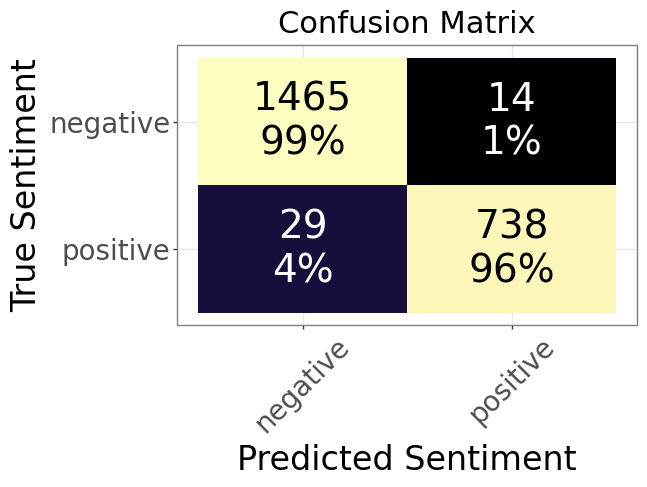

In [4]:
from functools import partial


iemocap_positive_emotions = ["happy", "excited"]
iemocap_negative_emotions = ["angry", "sad", "frustrated"]


iemocap_classify_sentiment = partial(
    utils.classify_sentiment,
    positive=iemocap_positive_emotions,
    negative=iemocap_negative_emotions,
)

df["emotion_sentiment"] = df["target"].apply(iemocap_classify_sentiment)
df_long = df.melt(
    id_vars=["emotion_sentiment", "target"],
    value_vars=["output", "output_concat"],
    var_name="source",
    value_name="output_long",
)
df_long["emotion_sentiment_prediction"] = df_long["output_long"].apply(
    iemocap_classify_sentiment
)


utils.print_confusion_matrix(
    df_long,
    target_labels=["positive", "negative"],
    output_column="emotion_sentiment_prediction",
    target_column="emotion_sentiment",
    xlab_name="Predicted Sentiment",
    ylab_name="True Sentiment",
    text_size=28,
    label_scaling_adjustment=4,
    name="images/sentiment_iemocap_cm.png",
)

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/negative_iemocap_cm.png


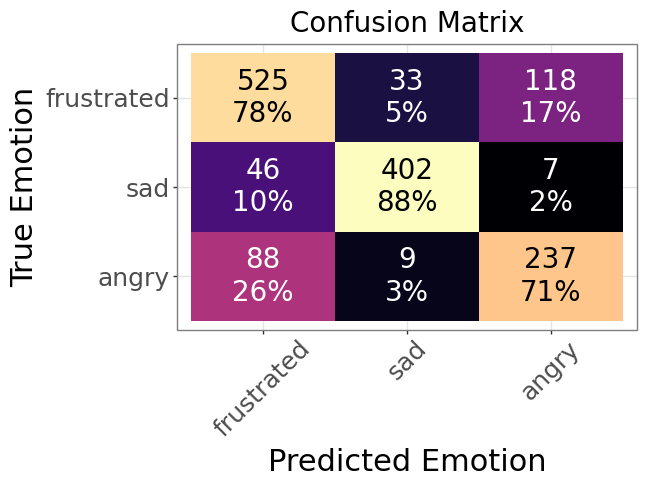

In [6]:
utils.print_confusion_matrix(
    df_long,
    target_labels=iemocap_negative_emotions,
    output_column="output_long",
    target_column="target",
    text_size=20,
    label_scaling_adjustment=2,
    name="images/negative_iemocap_cm.png",
)

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/positive_iemocap_cm.png


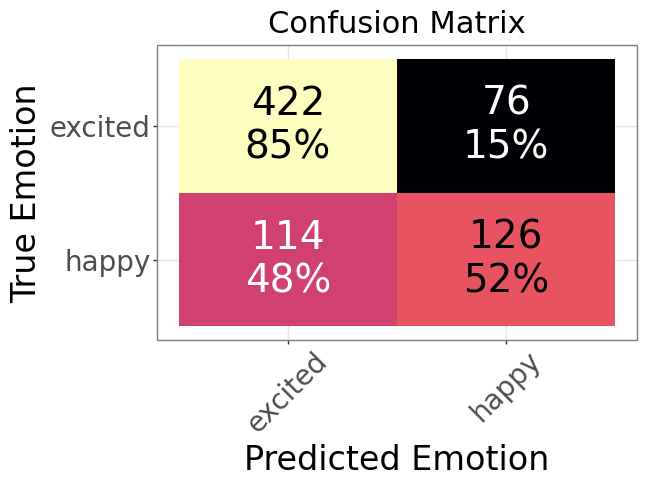

In [7]:
utils.print_confusion_matrix(
    df_long,
    target_labels=iemocap_positive_emotions,
    output_column="output_long",
    target_column="target",
    text_size=28,
    label_scaling_adjustment=4,
    name="images/positive_iemocap_cm.png",
)

In [8]:
fusion_model = df["target"] == df["output"] 
concat_model = df["target"] == df["output_concat"]  

# Define negations
not_fusion_model = ~fusion_model
not_concat_model = ~concat_model

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/discussion_iemocap_diff_cm.png


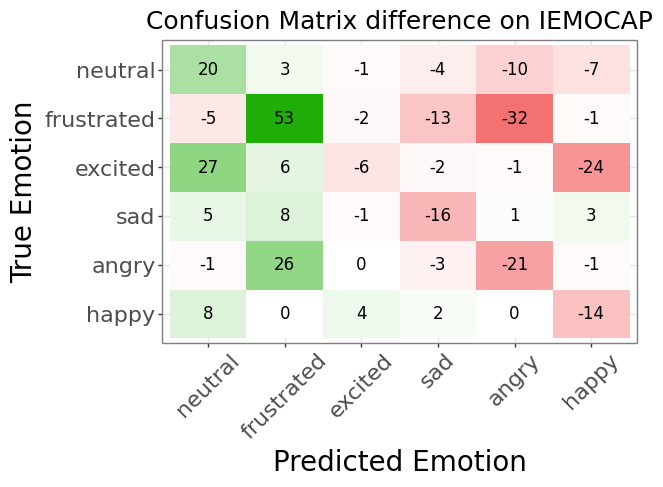

In [9]:
utils.print_confusion_matrix_difference(df, target_labels=labels[::-1], output_column1="output", output_column2="output_concat", name = "images/discussion_iemocap_diff_cm.png", title="Confusion Matrix difference on IEMOCAP")

In [22]:
def iou(df, label):
    diff = len(df[(df["target"] == label) & (df["output"] == label)]) - len(df[(df["target"] == label) & (df["output_concat"] == label)])
    inter = df[(df["target"] == label) & (df["output"] == label)].index.intersection(df[(df["target"] == label) & (df["output_concat"] == label)].index)
    union = df[(df["target"] == label) & (df["output"] == label)].index.union(df[(df["target"] == label) & (df["output_concat"] == label)].index)
    return float(len(inter) / (len(union)-abs(diff)))

iou(df, "happy")

0.696969696969697

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

for label in labels:
    y_true = df["target"].apply(lambda x: 1 if x == label else 0)
    y_pred_fusion = df["output"].apply(lambda x: 1 if x == label else 0)
    y_pred_concat = df["output_concat"].apply(lambda x: 1 if x == label else 0)

    pre_label = precision_score(y_true, y_pred_fusion) * 100
    rec_label = recall_score(y_true, y_pred_fusion) * 100
    pre_label_ierc = precision_score(y_true, y_pred_concat) * 100
    rec_label_ierc = recall_score(y_true, y_pred_concat) * 100
    f1_fusion = f1_score(y_true, y_pred_fusion) * 100
    f1_concat = f1_score(y_true, y_pred_concat) * 100
    
    print(f"F1-score\t für Label {label}: Fusion: {f1_fusion:.2f} - Concat: {f1_concat:.2f} - Different: {(f1_fusion - f1_concat):.2f}")
    print(f"Precision\t für Label {label}: Fusion: {pre_label:.2f} - Concat: {pre_label_ierc:.2f} - Differenz: {(pre_label - pre_label_ierc):.2f}")
    print(f"Recall\t\t für Label {label}: Fusion: {rec_label:.2f} - Concat: {rec_label_ierc:.2f} - Differenz: {(rec_label - rec_label_ierc):.2f}")
    print()

F1-score	 für Label neutral: Fusion: 73.06 - Concat: 72.99 - Different: 0.07
Precision	 für Label neutral: Fusion: 69.23 - Concat: 73.87 - Differenz: -4.64
Recall		 für Label neutral: Fusion: 77.34 - Concat: 72.14 - Differenz: 5.21

F1-score	 für Label frustrated: Fusion: 70.92 - Concat: 65.65 - Different: 5.27
Precision	 für Label frustrated: Fusion: 66.59 - Concat: 69.82 - Differenz: -3.23
Recall		 für Label frustrated: Fusion: 75.85 - Concat: 61.94 - Differenz: 13.91

F1-score	 für Label excited: Fusion: 71.72 - Concat: 73.04 - Different: -1.31
Precision	 für Label excited: Fusion: 74.02 - Concat: 74.56 - Differenz: -0.54
Recall		 für Label excited: Fusion: 69.57 - Concat: 71.57 - Differenz: -2.01

F1-score	 für Label sad: Fusion: 82.13 - Concat: 82.61 - Different: -0.48
Precision	 für Label sad: Fusion: 85.78 - Concat: 80.08 - Differenz: 5.70
Recall		 für Label sad: Fusion: 78.78 - Concat: 85.31 - Differenz: -6.53

F1-score	 für Label angry: Fusion: 65.45 - Concat: 65.65 - Differen

### Weitere Statistiken
Hier werden weitere Statistiken genannt, wie das Klassifizierungsverhalten der einzelnen Teilmodelle ist.
Es wurden einmal die Ergebnisse von InstructERC, dem Late-Fusion Modell audio output, und dem kombinierten Modell berechnet


In [11]:
# 2. late-fusion Model (F)
df_F = df[fusion_model]
print(f"In total, {len(df_F)} samples were recognized by the late-fusion model.")

# 3. concat Model (C)
df_C = df[concat_model]
print(f"In total, {len(df_C)} samples were recognized by the concat model.")


# 5. NOT late-fusion Model (¬F)
df_not_F = df[not_fusion_model]
print(f"In total, {len(df_not_F)} samples were NOT recognized by the late-fusion model.")

# 6. NOT concat Model (¬C)
df_not_C = df[not_concat_model]
print(f"In total, {len(df_not_C)} samples were NOT recognized by the concat model.")


# 9. late-fusion AND concat Models (F ∧ C)
df_F_and_C = df[fusion_model & concat_model]
print(f"In total, {len(df_F_and_C)} samples were recognized by both the late-fusion and concat models.")


# 13. late-fusion AND NOT concat Models (F ∧ ¬C)
df_F_and_not_C = df[fusion_model & not_concat_model]
print(f"In total, {len(df_F_and_not_C)} samples were recognized by the late-fusion model but NOT by the concat model.")


# 15. concat AND NOT late-fusion Models (C ∧ ¬F)
df_C_and_not_F = df[concat_model & not_fusion_model]
print(f"In total, {len(df_C_and_not_F)} samples were recognized by the concat model but NOT by the late-fusion model.")


# 18. NOT late-fusion AND NOT concat Models (¬F ∧ ¬C)
df_not_F_and_not_C = df[not_fusion_model & not_concat_model]
print(f"In total, {len(df_not_F_and_not_C)} samples were NOT recognized by both the late-fusion and concat models.")


In total, 1151 samples were recognized by the late-fusion model.
In total, 1135 samples were recognized by the concat model.
In total, 471 samples were NOT recognized by the late-fusion model.
In total, 487 samples were NOT recognized by the concat model.
In total, 1003 samples were recognized by both the late-fusion and concat models.
In total, 148 samples were recognized by the late-fusion model but NOT by the concat model.
In total, 132 samples were recognized by the concat model but NOT by the late-fusion model.
In total, 339 samples were NOT recognized by both the late-fusion and concat models.
